<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/mmdet_custom_config.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMDetection Custom Config

When creating an MMDetection `model`, the model `config` object is stored in `model.cfg` and the pretrained weight file path is stored in `model.weights_path`. In order to update model config attribute, you need to create an `cfg_options` dictionary: 


**Example: Changing loss weights for loss_bbox and loss_cls**

You can pass the `cfg_options` argument when creation a model

  ```python
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x
  'cfg_options' = { 
    'model.bbox_head.loss_bbox.loss_weight': 2,
    'model.bbox_head.loss_cls.loss_weight': 0.8 }

  # Passing cfg_options to the `model()` method to update loss weights
  model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), cfg_options=cfg_options)
  ``` 

## Install IceVision and IceData
The following downloads and runs a short shell script. The script installs IceVision, IceData, the MMDetection library, and Yolo v5 as well
as the fastai and pytorch lightning engines.

Install from pypi...

In [ ]:
# Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# Choose your installation target: cuda11 or cuda10 or cpu
!bash icevision_install.sh cuda11

... or from icevision master

In [ ]:
# # Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
# !wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# # Choose your installation target: cuda11 or cuda10 or cpu
# !bash icevision_install.sh cuda11 master

In [ ]:
# Restart kernel after installation
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

## Imports
All of the IceVision components can be easily imported with a single line.


In [ ]:
from icevision.all import *

## Download and prepare a dataset
Now we can start by downloading the Fridge Objects dataset. This tiny dataset contains 134 images of 4 classes:
- can, 
- carton, 
- milk bottle, 
- water bottle.

IceVision provides methods to load a dataset, parse annotation files, and more.

For more information about how the fridge dataset as well as its corresponding parser, check out the [fridge folder](https://github.com/airctic/icedata/tree/master/icedata/datasets/fridge) in icedata.

In [2]:
# Download the dataset
url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip"
dest_dir = "fridge"
data_dir = icedata.load_data(url, dest_dir)

## Parse the dataset


In [3]:
# Create the parser
parser = parsers.VOCBBoxParser(annotations_dir=data_dir / "odFridgeObjects/annotations", images_dir=data_dir / "odFridgeObjects/images")

In [ ]:
# Parse annotations to create records
train_records, valid_records = parser.parse()
parser.class_map

## Creating datasets with augmentations and transforms

In [5]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [6]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

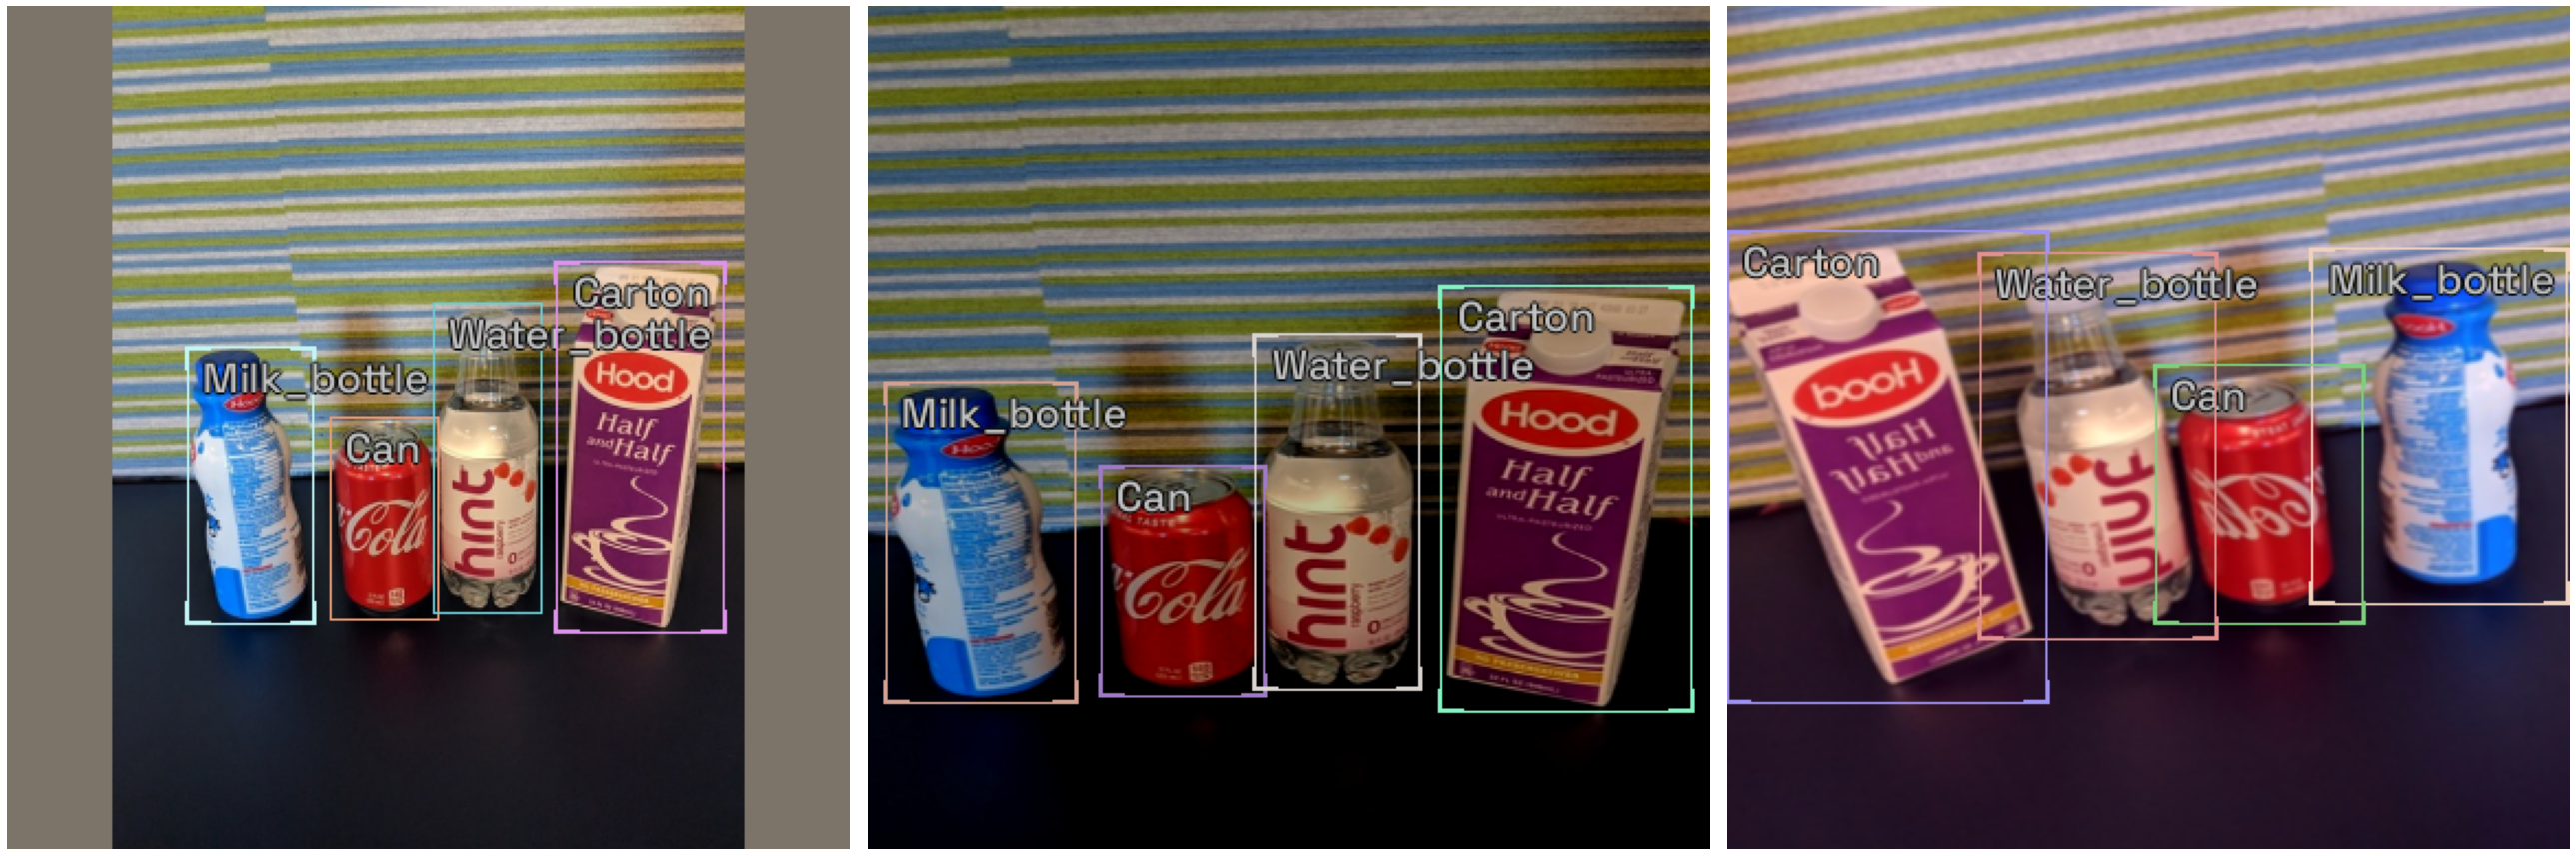

In [7]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

## Creating a model
This shows how to customize a retinanet model by using the `cfg_options` object:
```
model_type = models.mmdet.retinanet
backbone = model_type.backbones.resnet50_fpn_1x(pretrained=True, cfg_options=cfg_options)
```
As pretrained models are used by default, we typically leave this out of the backbone creation step.

We've selected a few of the many options below. You can easily pick which option you want to try by setting the value of `selection`. This shows you how to easily customize your model.


In [8]:
# Just the config options you would like to update

selection = 0

extra_args = {}

# Example: Changing both loss weights: loss_bbox, loss_cls
if selection == 0:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x
  cfg_options = { 
    'model.bbox_head.loss_bbox.loss_weight': 2,
    'model.bbox_head.loss_cls.loss_weight': 0.8,
     }

# Example: changing anchor boxes ratios:
elif selection == 1:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x
  cfg_options = { 
    'model.bbox_head.anchor_generator.ratios': [1.0] 
    }


cfg_options

{'model.bbox_head.loss_bbox.loss_weight': 2,
 'model.bbox_head.loss_cls.loss_weight': 0.8}


Now it is just a one-liner to instantiate the model. If you want to try another *option*, just edit the line at the top of the previous cell.

In [ ]:
# Instantiate the model and pass the `cfg_options` dictionary
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), cfg_options=cfg_options) 

In [10]:
print(model.bbox_head.loss_bbox.loss_weight)
print(model.bbox_head.loss_cls.loss_weight)
print(model.bbox_head.anchor_generator.ratios)

2
0.8
tensor([0.50000, 1.00000, 2.00000])


In [11]:
print(model.cfg.model.bbox_head.loss_cls.loss_weight)
print(model.cfg.model.bbox_head.loss_bbox.loss_weight)
print(model.cfg.model.bbox_head.anchor_generator.ratios)

0.8
2
[0.5, 1.0, 2.0]


## Print config settings

In [12]:
# You have access to model's weights_path
model.weights_path

Path('checkpoints/retinanet/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth')

In [ ]:
# You also have access to the whole config object
model.cfg.__dict__

In [14]:
# Double checking model new attributes for `loss_cls`
model.cfg.model.bbox_head.loss_cls

{'alpha': 0.25,
 'gamma': 2.0,
 'loss_weight': 0.8,
 'type': 'FocalLoss',
 'use_sigmoid': True}

In [15]:
# Double checkingmodel new attributes for `anchor_generator`
model.cfg.model.bbox_head.anchor_generator

{'octave_base_scale': 4,
 'ratios': [0.5, 1.0, 2.0],
 'scales_per_octave': 3,
 'strides': [8, 16, 32, 64, 128],
 'type': 'AnchorGenerator'}

## Data Loader

The Data Loader is specific to a model_type. The job of the data loader is to get items from a dataset and batch them up in the specific format required by each model. This is why creating the data loaders is separated from creating the datasets.

We can take a look at the first batch of items from the `valid_dl`. Remember that the `valid_tfms` only resized (with padding) and normalized records, so different images, for example, are not returned each time. This is important to provide consistent validation during training.

In [ ]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

## Metrics

The fastai and pytorch lightning engines collect metrics to track progress during training. IceVision provides metric classes that work across the engines and libraries.

The same metrics can be used for both fastai and pytorch lightning.

In [18]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

## Training

IceVision is an agnostic framework meaning it can be plugged into other DL learning engines such as [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).  


### Training using fastai

In [19]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=0.00010964782268274575)

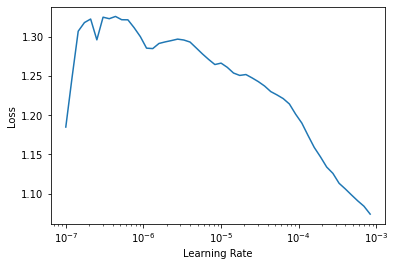

In [20]:
learn.lr_find()

# For Sparse-RCNN, use lower `end_lr`
# learn.lr_find(end_lr=0.005)

In [21]:
learn.fine_tune(20, 1e-4, freeze_epochs=1)

### Training using Pytorch Lightning

In [ ]:
class LightModel(model_type.lightning.ModelAdapter):
    def configure_optimizers(self):
        return SGD(self.parameters(), lr=1e-4)
    
light_model = LightModel(model, metrics=metrics)

In [ ]:
trainer = pl.Trainer(max_epochs=20, gpus=1)
trainer.fit(light_model, train_dl, valid_dl)

## Using the model - inference and showing results

The first step in reviewing the model is to show results from the validation dataset. This is easy to do with the `show_results` function.

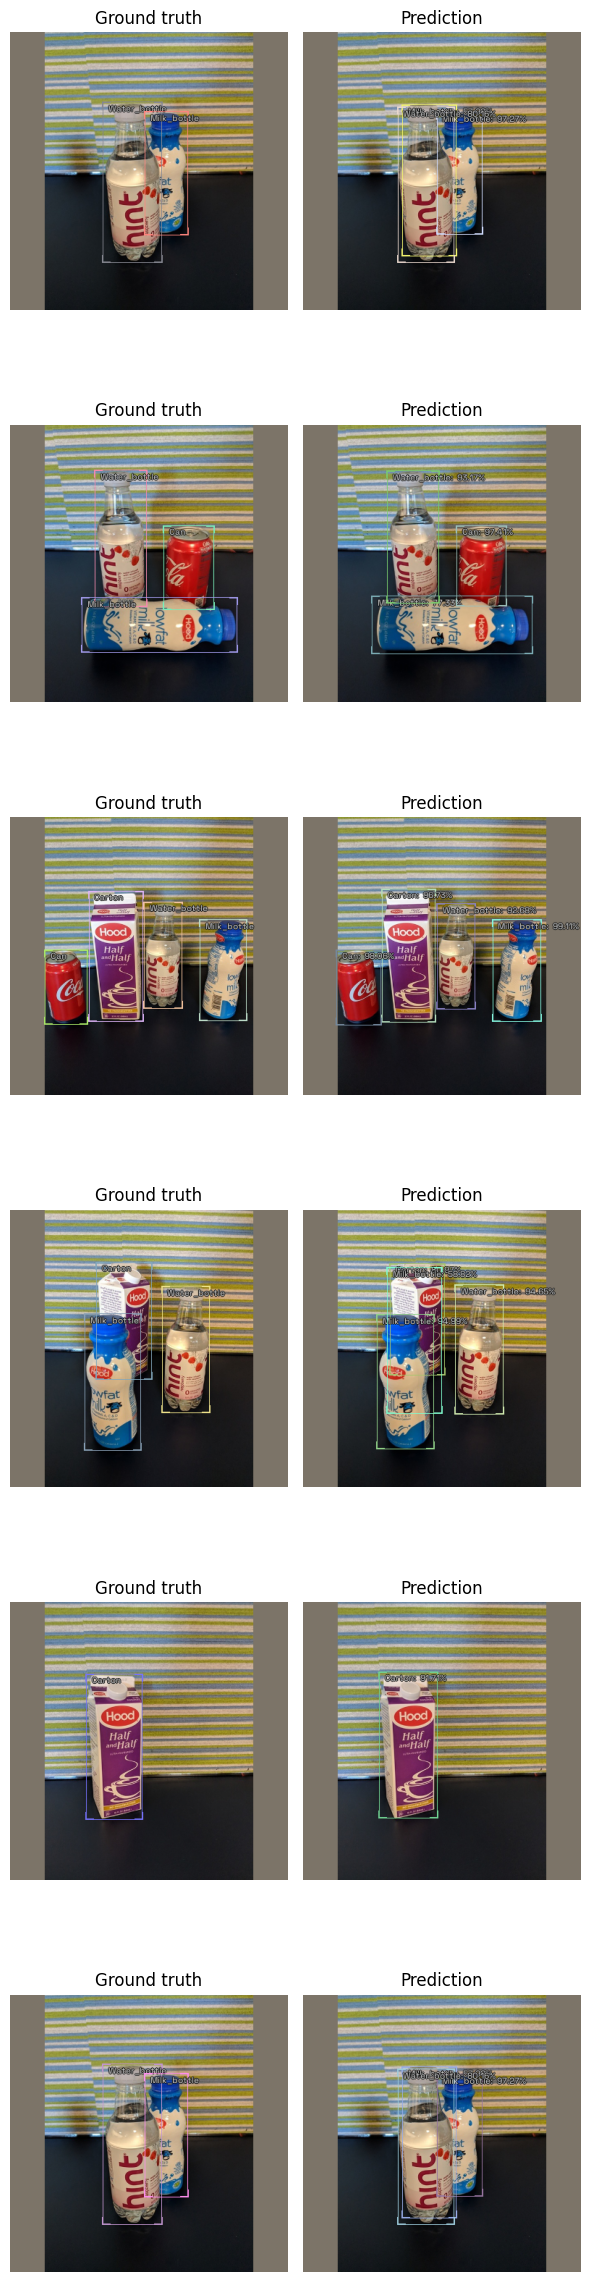

In [ ]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

### Prediction

> NOTE: For a more detailed look at inference check out the [inference tutorial](https://airctic.com/dev/inference/)

In [ ]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

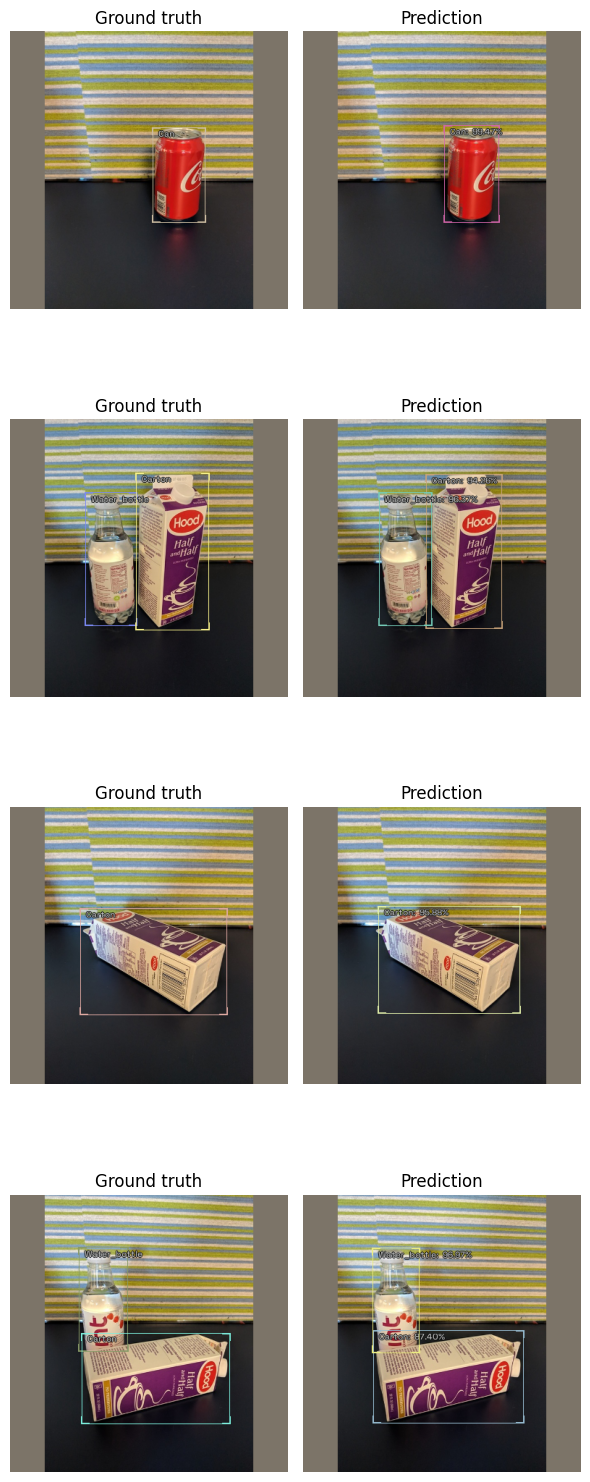

In [ ]:
show_preds(preds=preds[:4])

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).